<a href="https://colab.research.google.com/github/RobertoRamosCastro/ImageClassification/blob/main/CNN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import keras 
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

print("keras version", keras.__version__)



# Cargar base de datos de diferentes tipos de fuentes
import os 
from six.moves import urllib

file_url = 'https://github.com/bloolizard/PlayWithTensorFlow/raw/master/data_with_labels.npz'
file_name = 'data_with_labels.npz'

if not os.path.exists(file_name):
  urllib.request.urlretrieve(file_url, file_name)

# Cargar datos
data = np.load(file=file_name)

train= data['arr_0'] / 255
labels= data['arr_1']

onehot = to_categorical(labels, num_classes=len(np.unique(labels)))


#train.shape
labels

# Dividir datos de entrenamineto al 90% y el resto para validacion
np.random.seed(100)

indices = np.random.permutation(train.shape[0])

valid_cnt = int(train.shape[0] * 0.1)

test_idx, training_idx = indices[:valid_cnt],\
                         indices[valid_cnt:]
  
test, train = train[test_idx,:],\
              train[training_idx,:]
  
onehot_test, onehot_train = onehot[test_idx,:],\
                        onehot[training_idx,:]
train=train.reshape([-1,train.shape[1],train.shape[2],1])
test=test.reshape([-1,test.shape[1],test.shape[2],1])

print('Forma de datos de Entrenamiento=', train.shape , '\nForma de datos de Test=', test.shape)


In [2]:
# Cargando nuevo set de datos para la misma arq de CNN
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
data, metadata = tfds.load('cifar10', as_supervised=True, with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete9IBA6J/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete9IBA6J/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
train, test = data['train'], data['test']

In [5]:
print(train,'\n',test)

<PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))> 
 <PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [6]:
metadata

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='/root/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learn

In [7]:
class_names = metadata.features['label'].names
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
# Normalizar la data

def normalize(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, dtype=tf.float32)
  imagenes /= 255
  return imagenes, etiquetas


In [ ]:
# Splitear el conjunto de datos en 80(entrenamiento)-20(validacion)

In [13]:
# Preprocesamiento de los datos

train = train.map(normalize)
#test = test.map(normalize)

# Cargarlo en la memoria de cache
train = train.cache()

BATCH_SIZE = 32
train = train.shuffle(metadata.splits['train'].num_examples)
train = train.batch(BATCH_SIZE)
train = train.prefetch(tf.data.experimental.AUTOTUNE)

# Si queremos preprocesar los datos tendrian que ser tambien del set de validacion, del test
#test = test.batch(BATCH_SIZE) 
#test = test.prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

import matplotlib.pyplot as plt

for imagen, lbl, in train.take(1):
  break
  imagen = imagen.numpy().reshape((28,28)) # Redimensionamos

# Dibujar la imagen
plt.figure()
plt.imshow(imagen)
plt.colorbar()
plt.grid(False)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

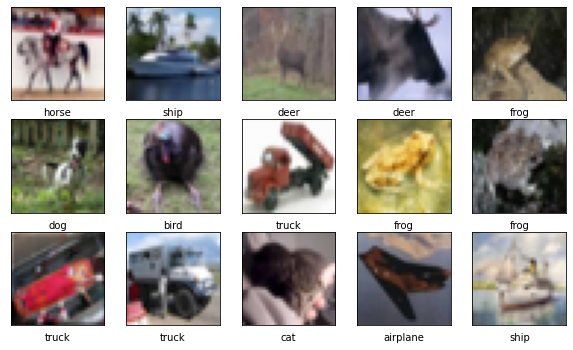

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(train.take(15)):
  imagen = imagen.numpy()
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(class_names[etiqueta])
plt.show

plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(train.take(1)):
  imagen = imagen.numpy()
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(class_names[etiqueta])
plt.show

In [12]:
ds = tfds.load('cifar10', split='train')
ds = ds.take(1)

for example in ds:
  print(list(example.keys()))
  image = example['image']
  tamano_entrada = image.shape
  label = example['label']
  print(tamano_entrada, label)

['id', 'image', 'label']
(32, 32, 3) tf.Tensor(7, shape=(), dtype=int64)


In [15]:
# Definir la arquitectura de nuestra CNN
from keras.layers.merging.add import add
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Flatten, Dropout
from keras import Input

num_clases = len(class_names)

model = Sequential()

# Hidden layer 1
model.add(Convolution2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

# Hidden layer 2
model.add(Convolution2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Hidden layer 3
model.add(Convolution2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_clases, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

In [16]:
# Definir modelo

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# Entrenar modelo

history = model.fit(train,
          epochs=50,
          batch_size=BATCH_SIZE,
          verbose=2)

Epoch 1/50
1563/1563 - 23s - loss: 1.6498 - accuracy: 0.3910 - 23s/epoch - 15ms/step
Epoch 2/50
1563/1563 - 6s - loss: 1.2887 - accuracy: 0.5426 - 6s/epoch - 4ms/step
Epoch 3/50
1563/1563 - 6s - loss: 1.1331 - accuracy: 0.6046 - 6s/epoch - 4ms/step
Epoch 4/50
1563/1563 - 6s - loss: 1.0293 - accuracy: 0.6409 - 6s/epoch - 4ms/step
Epoch 5/50
1563/1563 - 6s - loss: 0.9522 - accuracy: 0.6686 - 6s/epoch - 4ms/step
Epoch 6/50
1563/1563 - 6s - loss: 0.8959 - accuracy: 0.6881 - 6s/epoch - 4ms/step
Epoch 7/50
1563/1563 - 6s - loss: 0.8344 - accuracy: 0.7109 - 6s/epoch - 4ms/step
Epoch 8/50
1563/1563 - 6s - loss: 0.7968 - accuracy: 0.7229 - 6s/epoch - 4ms/step
Epoch 9/50
1563/1563 - 6s - loss: 0.7623 - accuracy: 0.7369 - 6s/epoch - 4ms/step
Epoch 10/50
1563/1563 - 6s - loss: 0.7220 - accuracy: 0.7490 - 6s/epoch - 4ms/step
Epoch 11/50
1563/1563 - 6s - loss: 0.6857 - accuracy: 0.7601 - 6s/epoch - 4ms/step
Epoch 12/50
1563/1563 - 6s - loss: 0.6649 - accuracy: 0.7683 - 6s/epoch - 4ms/step
Epoch 13/5

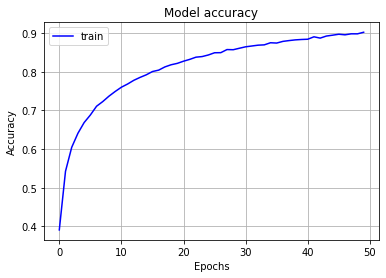

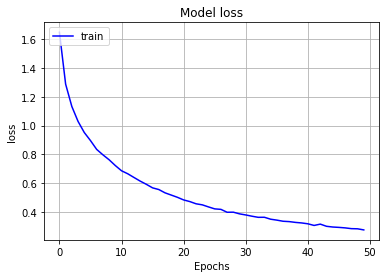

In [19]:
# Graficar modelo

loss = history.history['loss']
accuracy = history.history['accuracy']
#val_loss = history.history['val_loss']
#val_accuracy = history.history['val_accuracy']

plt.plot(accuracy, 'b-')
#plt.plot(val_accuracy, 'r-')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

plt.plot(loss, 'b-')
#plt.plot(val_loss, 'r-')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')

plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()


# Con 16 y 32 filtros en dos hidden layers + 3,3 el tamaño de cada filtro y sin regularizacion (creo q produce overfitting por la grafica, q el loss aumenta en vez de bajar continuamente)

Val_accuracy maxima: 0.68  
Train_accuracy maxima: 0.82  
Val_loss maxima: 1.3  

# Con 4 filtros en dos hidden layers + 5,5 el tamaño de cada filtro y con dropout 0.5

Accuracy maxima de ~ 0.5 

max_acc_val = max(val_accuracy)
print('Val_accuracy maxima:',max_acc_val)

max_acc_train = max(accuracy)
print('Train_accuracy maxima:',max_acc_train)


max_loss = max(val_loss)
print('Val_loss maxima:',max_loss)




# Con 16 y 32 filtros en dos hidden layers + 3,3 el tamaño de cada filtro y con dropout 0.3, y primera capa densa con 512 neuronas se produce mucho overfitting

Val_accuracy maxima: 0.71  
Train_accuracy maxima: 0.97  
Val_loss maxima: 2.19  

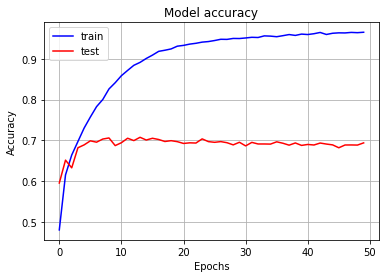

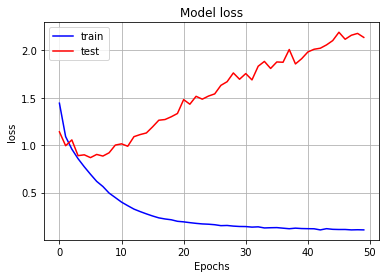

# Con 16 y 32 filtros en dos hidden layers + 3,3 el tamaño de cada filtro y con dropout 0.5, y primera capa densa con 256 neuronas se produce menos overfitting

Val_accuracy maxima: 0.71  
Train_accuracy maxima: 0.87  
Val_loss maxima: 1.39  

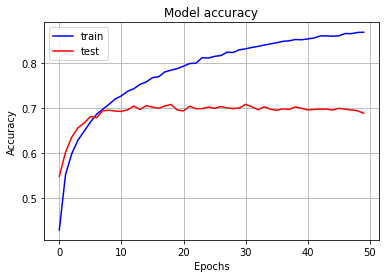

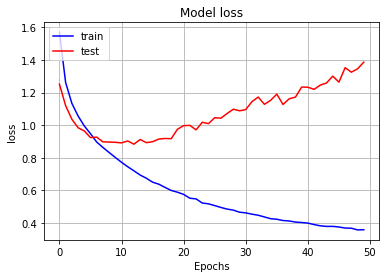

# Con 16 y 32 filtros en dos hidden layers + 3,3 el tamaño de cada filtro y con dropout 0.5, y primera capa densa con 128 neuronas se produce menos aun overfitting

Val_accuracy maxima: 0.7  
Train_accuracy maxima: 0.78  
Val_loss maxima: 1.35 

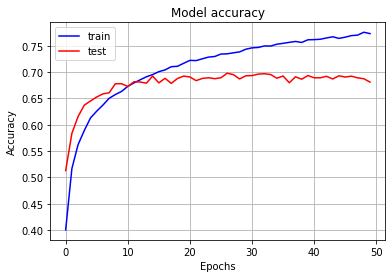

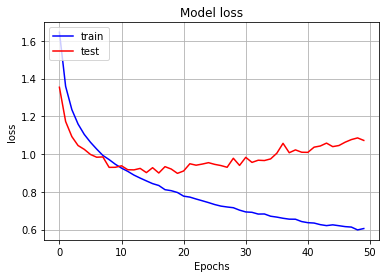

# Con 32 y 64 filtros en dos hidden layers + 3,3 el tamaño de cada filtro y sin , y primera capa densa con 128 neuronas se produce muchisimo overfitting

Val_accuracy maxima: 0.7  
Train_accuracy maxima: 0.98  
Val_loss maxima: 3.8  

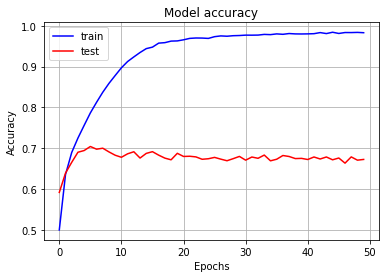


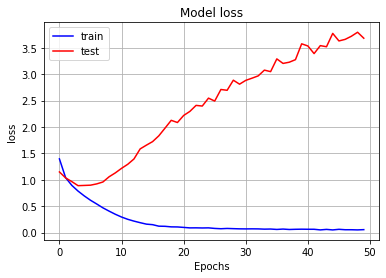

# Con 32, 64, 128 filtros en tres hidden layers + 3,3 el tamaño de cada filtro y con droput 0.5 , y primera capa densa con 128 neuronas se produce ? overfitting

Val_accuracy maxima: 0.74  
Train_accuracy maxima: 0.9  
Val_loss maxima: 1.44  

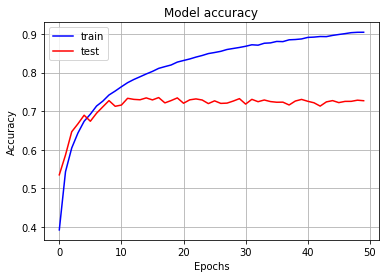

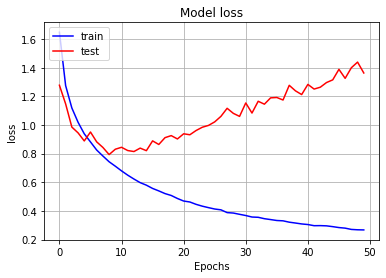

In [83]:
max_acc_val = max(val_accuracy)
print('Val_accuracy maxima:',round(max_acc_val, 2))

max_acc_train = max(accuracy)
print('Train_accuracy maxima:',round(max_acc_train,2 ))


max_loss = max(val_loss)
print('Val_loss maxima:',round(max_loss,2 ))

Val_accuracy maxima: 0.74
Train_accuracy maxima: 0.9
Val_loss maxima: 1.44


In [84]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [85]:
%cd '/content/gdrive/MyDrive/AtecneaYTB'

/content/gdrive/MyDrive/AtecneaYTB


In [88]:
!ls

CNN_Keras.ipynb  modelo


In [87]:
!mkdir modelo

In [ ]:
# Guardar modelo
import os 

dir = '/content/gdrive/MyDrive/AtecneaYTB/modelo'

if not os.path.exists(dir):
  os.mkdir('modelo')

model.save('/content/gdrive/MyDrive/AtecneaYTB/modelo/modelo.h5')
model.save_weights('/content/gdrive/MyDrive/AtecneaYTB/modelo/pesos.h5')

In [ ]:
# Prediccion

import keras
import numpy as np
import cv2

# Cargar modelo guardado
#model = keras.models.load_model('ruta/a/tu/modelo.h5')

# Cargar datos para predecir
img = cv2.imread('3923.jpg', cv2.IMREAD_GRAYSCALE)

# Asegurarnos de que la imagen tenga el tamaño adecuado
img = cv2.resize(img, (36, 36))

# Convertir imagen a matriz numpy y normalizar valores de pixel
X_pred = np.array([img])
X_pred_norm = X_pred / 255.0

# Realizar predicción
y_pred = model.predict(X_pred_norm)

# Obtener etiqueta predicha
label_pred = np.argmax(y_pred)

# Imprimir etiqueta predicha
print("La etiqueta predicha es:", label_pred)



1/1 [==============================] - 0s 23ms/step
La etiqueta predicha es: 3


import tensorflow-gpu si tienes una gpu en tu equipo